In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import time

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
cuda2 = True # torch.cuda.is_available() can be used to check if a gpu is available - I just set it to False
batch_size2 = 128
log_interval2 = 10

torch.manual_seed(1) # args.seed

device = torch.device("cuda" if cuda2 else "cpu") # args.cuda
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda2 else {} # args.cuda

# Get train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
# Define VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)

        self.fc21 = nn.Linear(100, latent_dim) # Latent space of 2D
        self.fc22 = nn.Linear(100, latent_dim) # Latent space of 2D

        self.fc3 = nn.Linear(latent_dim, 100) # Latent space of 2D
        self.fc3a = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
VAE_model_2 = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(VAE_model_2.parameters(), lr=1e-3)

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO


def train(epoch):
    VAE_model_2.train() # so that everything has gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = VAE_model_2(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset)


def test(epoch):
    VAE_model_2.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = VAE_model_2(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

fc_train_losses = []
fc_test_losses = []
start_time = time.time()
for epoch in range(1, 10 + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    fc_train_losses += [train_loss]
    fc_test_losses += [test_loss]
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device) # 20 -> 2
        sample = VAE_model_2.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'samples_1/sample_' + str(epoch) + '.png')
end_time = time.time()
vae_time = end_time - start_time
vae_time

====> Epoch: 1 Average loss: 186.2785
====> Test set loss: 166.4521
====> Epoch: 2 Average loss: 162.4567
====> Test set loss: 159.5572
====> Epoch: 3 Average loss: 156.8511
====> Test set loss: 155.0284
====> Epoch: 4 Average loss: 153.4704
====> Test set loss: 152.2039
====> Epoch: 5 Average loss: 151.0167
====> Test set loss: 150.7347
====> Epoch: 6 Average loss: 149.1751
====> Test set loss: 149.0438
====> Epoch: 7 Average loss: 147.7604
====> Test set loss: 147.7037
====> Epoch: 8 Average loss: 146.6334
====> Test set loss: 147.1914
====> Epoch: 9 Average loss: 145.7678
====> Test set loss: 146.0272
====> Epoch: 10 Average loss: 145.0005
====> Test set loss: 146.1229


80.15025019645691

### Find expected value in latent space for each number

In [ ]:
mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((128*B,2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k,:,:,:]
        an_img_flat = torch.flatten(an_img).to(device)
        mean_img = VAE_model_2.encode(an_img_flat)[0]
        results[l] = mean_img
        l +=1
results = results[:l,:]
all_labels = all_labels[:l]

### Plot

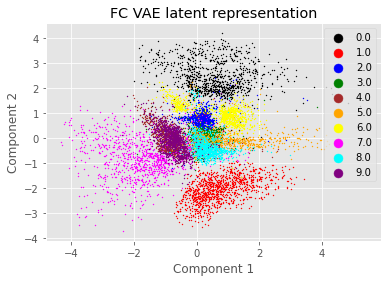

In [ ]:
results_for_plot = results.detach().numpy()

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("FC VAE latent representation")
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Calculate the silhouette score for the clustering
silhouette_score(np.column_stack((scatter_x, scatter_y)), group)

0.100671194

In [ ]:
VAE_model_20 = VAE(latent_dim=20).to(device)
optimizer = optim.Adam(VAE_model_20.parameters(), lr=1e-3)

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO


def train(epoch):
    VAE_model_20.train() # so that everything has gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = VAE_model_20(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset)


def test(epoch):
    VAE_model_20.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = VAE_model_20(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

fc_train_losses_20 = []
fc_test_losses_20 = []

for epoch in range(1, 10 + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    fc_train_losses_20 += [train_loss]
    fc_test_losses_20 += [test_loss]
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device) # 20 -> 2
        sample = VAE_model_20.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'samples_2/sample_' + str(epoch) + '.png')

KeyboardInterrupt: ignored

In [ ]:
mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((128*B,20))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k,:,:,:]
        an_img_flat = torch.flatten(an_img).to(device)
        mean_img = VAE_model_20.encode(an_img_flat)[0]
        results[l] = mean_img
        l +=1
results = results[:l,:]
all_labels = all_labels[:l]

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(results.detach())

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 1.686s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.966985
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.206055
[t-SNE] KL divergence after 300 iterations: 2.942914


[1. 3. 5. 6. 9. 0. 2. 7. 8. 4.]


[Text(0.5, 1.0, 'tsne FC VAE')]

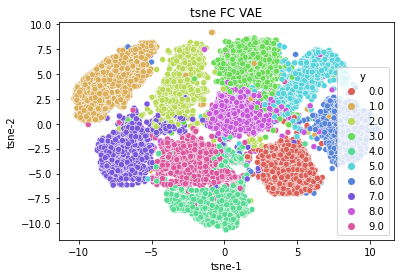

In [ ]:
import pandas as pd
import seaborn as sns

tsne_df = pd.DataFrame(
    data=tsne_results, 
    columns=['tsne-1', 'tsne-2'])

tsne_df["y"] = all_labels
print(tsne_df["y"].unique())
plt.figure()
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    data=tsne_df,
    hue="y",
    palette=sns.color_palette("hls", 10),
    legend="full"
).set(title='tsne FC VAE')

# 2. Now let's visualize the output in a different way...

In [ ]:
M = 12
x = torch.linspace(start=0, end=1, steps=M+2)
x = x[:-1]
x = x[1:]

In [ ]:
mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc = 0, scale = 1)
gauss_x = gauss.icdf(mesh_x)#.flip(0)
gauss_y = gauss.icdf(mesh_y)

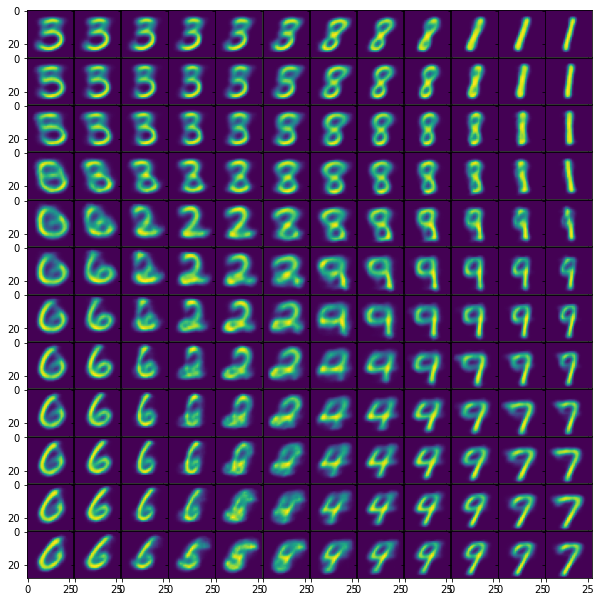

In [ ]:
fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(8, 8), sharex = True, sharey = True)
for i in range(M):
    for j in range(M):
        x_val = gauss_x[i,j].item()
        y_val = gauss_y[i,j].item()
        im = VAE_model_2.decode(torch.Tensor([y_val, x_val]).to(device))
        im_plt = im.reshape((28,28))
        plot_me = im_plt.cpu().detach().numpy()
        ax[i,j].imshow(plot_me)

slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.show()

# torch.distributions

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self, z_dim=2):
        super(ConvVAE, self).__init__()

        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )

        self.fc1 = nn.Linear(64*7*7, 512)
        self.fc_mu = nn.Linear(512, z_dim)
        self.fc_logvar = nn.Linear(512, z_dim)

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 64*7*7),
            nn.ReLU()
        )

        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def encode(self, x):
        x = self.encoder(x)
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def decode(self, z):
        x = self.decoder(z)
        x = x.view(-1, 64, 7, 7)
        x = self.deconv1(x)
        x = F.relu(x)
        x = self.deconv2(x)
        x = torch.sigmoid(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        x = self.reparameterize(mu, logvar)

        return self.decode(x), mu, logvar

In [ ]:
conv_model_2 = ConvVAE().to(device)
optimizer = optim.Adam(conv_model_2.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO


def train():
    conv_model_2.train() # so that everything was gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = conv_model_2(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset)


def test():
    conv_model_2.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = conv_model_2(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return(test_loss)

conv_train_losses = []
conv_test_losses = []
start_time = time.time()
for epoch in range(1, 10 + 1):
    train_loss = train()
    test_loss = test()
    conv_train_losses += [train_loss]
    conv_test_losses += [test_loss]
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device) # 20 -> 2
        sample = conv_model_2.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'samples_3/sample_' + str(epoch) + '.png')
end_time = time.time()
vae_conv_time = end_time - start_time
vae_conv_time

====> Epoch: 1 Average loss: 180.9869
====> Test set loss: 162.3554
====> Epoch: 2 Average loss: 158.8296
====> Test set loss: 155.7869
====> Epoch: 3 Average loss: 154.2841
====> Test set loss: 152.8637
====> Epoch: 4 Average loss: 151.6703
====> Test set loss: 151.1492
====> Epoch: 5 Average loss: 149.8426
====> Test set loss: 149.3671
====> Epoch: 6 Average loss: 148.5946
====> Test set loss: 148.8911
====> Epoch: 7 Average loss: 147.3658
====> Test set loss: 147.0642
====> Epoch: 8 Average loss: 146.4226
====> Test set loss: 146.8141
====> Epoch: 9 Average loss: 145.6029
====> Test set loss: 145.9154
====> Epoch: 10 Average loss: 144.9071
====> Test set loss: 145.7419


83.71313953399658

### Find expected value in latent space for each number

In [ ]:
mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((128*B,2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k,:,:,:]
        mean_img = conv_model_2.encode(an_img.to(device).view(1,1,28,28))[0]
        results[l] = mean_img
        l +=1
results = results[:l,:]
all_labels = all_labels[:l]

### Plot

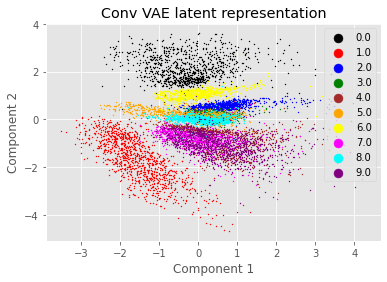

In [ ]:
results_for_plot = results.detach().numpy()

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Conv VAE latent representation")
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Calculate the silhouette score for the clustering
silhouette_score(np.column_stack((scatter_x, scatter_y)), group)



0.048730623

In [ ]:
conv_model_20 = ConvVAE(20).to(device)
optimizer = optim.Adam(conv_model_20.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO


def train():
    conv_model_20.train() # so that everything was gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = conv_model_20(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset)


def test():
    conv_model_20.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = conv_model_20(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return(test_loss)

conv_train_losses_20 = []
conv_test_losses_20 = []

for epoch in range(1, 10 + 1):
    train_loss = train()
    test_loss = test()
    conv_train_losses_20 += [train_loss]
    conv_test_losses_20 += [test_loss]
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device) # 20 -> 2
        sample = conv_model_20.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'samples_4/sample_' + str(epoch) + '.png')

====> Epoch: 1 Average loss: 160.6885
====> Test set loss: 120.1807


FileNotFoundError: ignored

In [ ]:
mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((128*B,20))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k,:,:,:]
        mean_img = conv_model_20.encode(an_img.to(device).view(1,1,28,28))[0]
        results[l] = mean_img
        l +=1
results = results[:l,:]
all_labels = all_labels[:l]

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(results.detach())

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 1.794s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.992697
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.812218
[t-SNE] KL divergence after 300 iterations: 2.900912


[8. 9. 6. 4. 5. 2. 3. 1. 7. 0.]


[Text(0.5, 1.0, 'tsne conv VAE')]

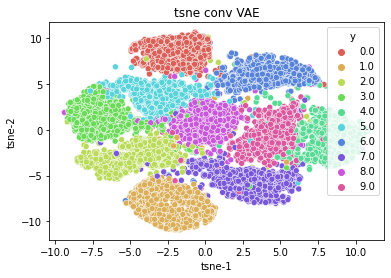

In [ ]:
import pandas as pd
import seaborn as sns

tsne_df = pd.DataFrame(
    data=tsne_results, 
    columns=['tsne-1', 'tsne-2'])

tsne_df["y"] = all_labels
print(tsne_df["y"].unique())
plt.figure()
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    data=tsne_df,
    hue="y",
    palette=sns.color_palette("hls", 10),
    legend="full"
).set(title='tsne conv VAE')

PPCA MODEL

In [ ]:
import torch
from torch.autograd import Variable
from PIL import Image as im

# Load data
data = train_loader.dataset.data

# Number of samples
N = len(data)

# Reshape data into vectors
data_vec = torch.reshape(data, (60000, 28*28)) # Make into vector

data_cov = torch.cov(data_vec.T)
data_eig = torch.linalg.eig(data_cov)

D = data_eig.eigenvectors.shape[1]
M = 2
sig_sq = 1/(D-M)*torch.sum(data_eig.eigenvalues[2:])

U_M = data_eig.eigenvectors[:,:2]
L_M = torch.diag(data_eig.eigenvalues[:2])
W = torch.matmul(U_M, (L_M-sig_sq*torch.eye(2))**0.5)
data_vec_double = data_vec.type(torch.DoubleTensor)
mu = torch.mean(data_vec_double, 0)

# Compute covariance matrix of latent variables
M = torch.matmul(W.T, W) + sig_sq * torch.eye(2)
# Compute latent variables
x_mu = data_vec_double.T - mu.repeat(N,1).T
temp = torch.inverse(M)@W.T

x_mu_complex = x_mu.type(torch.complex64)
temp_double = temp.type(torch.double)

z_values = temp_double@x_mu

In [ ]:
# Load data
data_test = test_loader.dataset.data

# Number of samples
N = len(data_test)

# Reshape data into vectors
data_vec_test = torch.reshape(data_test, (10000, 28*28)) # Make into vector

M = torch.matmul(W.T, W) + sig_sq * torch.eye(2)  # M = W.T*W + sigma^2*I
Minv = torch.inverse(M)  # LxL
latent_data = torch.matmul(Minv,W.T)
mu_test = torch.mean(data_vec_double, 0)
x_mu_test = data_vec_test.T - mu.repeat(10000,1).T
latent_data = torch.matmul(latent_data,x_mu_test.to(torch.complex64))

var1 = torch.matmul(W.T, W)
test = np.linalg.inv(var1)

created_data = torch.matmul(W, torch.from_numpy(test))

created_data = torch.matmul(created_data, M)
created_data = torch.matmul(created_data, latent_data.type(torch.complex64)) + mu.repeat(10000,1).T


torch.Size([2, 10000])
torch.Size([10000])


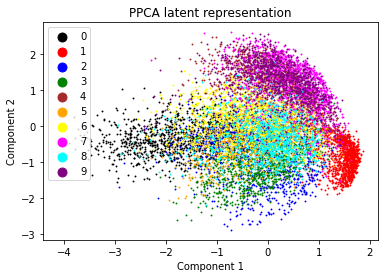

In [ ]:
results_for_plot = latent_data.to(torch.float).detach().cpu()
print(results_for_plot.shape)
scatter_x = results_for_plot[0,:]
scatter_y = results_for_plot[1,:]
print(scatter_x.shape)
group = test_loader.dataset.test_labels
cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PPCA latent representation")
plt.show()

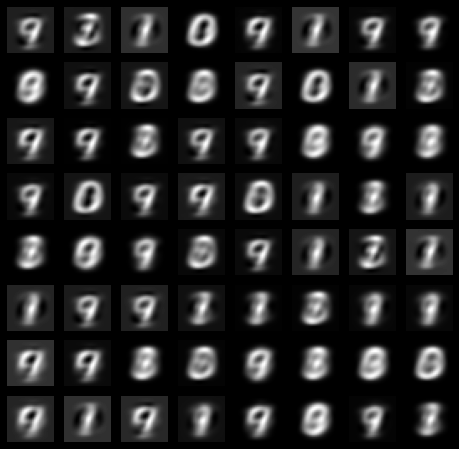

In [ ]:
import matplotlib.pyplot as plt

imgs = []
for i in range(64):
    img = created_data[:,i].type(torch.float).view(28,28)
    imgs.append(img)

fig, axs = plt.subplots(8, 8, figsize=(8, 8))
fig.set_facecolor("black")
axs = axs.ravel()
for i in range(64):
    axs[i].imshow(imgs[i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_facecolor("black")
plt.show()

img = created_data[:,0].type(torch.float)
image_array = img.view(28,28).numpy()
original = data_vec[0].reshape(28,28)
image = im.fromarray(image_array)
image = image.convert("L")
image1 = im.fromarray(original.numpy())
image1 = image1.convert("L")
image.save('11.jpeg')
image1.save('22.jpeg')

In [ ]:
from sklearn.metrics import mean_squared_error
mse_PPCA = 0
mse_VAE = 0
mse_VAE_conv = 0
for i in range(0,10000):
  img_index = i
  img = created_data[:,img_index].type(torch.float)
  image_array = img.view(28,28).numpy()

  original = data_vec_test[img_index].reshape(28,28)
  original_ = im.fromarray(original.numpy())
  original_ = original_.convert("L")
  created = im.fromarray(image_array)
  created = created.convert("L")
  if i < 10:
    original_.save('results/original' + str(img_index) + '.jpeg')
    created.save('results/PPCA_created' + str(img_index) + '.jpeg')

  mse_PPCA += mean_squared_error(original.reshape(-1), image_array.reshape(-1))
  #print(mse_PPCA)

  original = data_vec_test[img_index].reshape(28,28).to(float)

  encode_original = VAE_model_2.encode(original.view(28*28).to(torch.float).to(device))
  decode_original = VAE_model_2.decode(encode_original[0])
  mse_VAE += mean_squared_error(original.reshape(-1), decode_original.detach().cpu().reshape(-1))
  #print(mse_VAE)
  if i < 10:
    save_image(decode_original.view(1, 1, 28, 28),
                    'results/VAE_FFC_created' + str(img_index) + '.png')


  encode_original_conv = conv_model_2.encode(original.view(1,1,28,28).to(torch.float).to(device))
  decode_original_conv = conv_model_2.decode(encode_original_conv[0])
  mse_VAE_conv += mean_squared_error(original.reshape(-1), decode_original_conv.detach().cpu().reshape(-1))
  #print(mse_VAE_conv)
  if i < 10:
    save_image(decode_original_conv.view(1, 1, 28, 28),
                   'results/VAE_conv_created' + str(img_index) + '.png')

mse_PPCA /= 10000
mse_VAE /= 10000
mse_VAE_conv /= 10000
print(mse_PPCA)
print(mse_VAE)
print(mse_VAE_conv)

3619.908695581055
7387.733785078497
7399.062899147859


In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(an_img_flat.view(28*28).detach().cpu(), decode_original.view(28*28).detach().cpu())

In [ ]:
mse

5068.591264196713

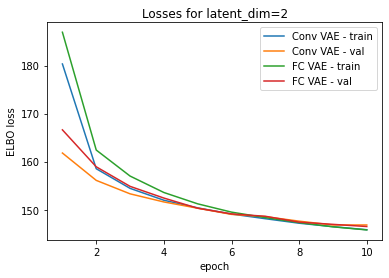

In [ ]:
y_ = conv_train_losses
y_1 = conv_test_losses
y_2 = fc_train_losses
y_3 = fc_test_losses
x_ = list(range(1, 10+1))
plt.plot(x_, y_, label="Conv VAE - train")
plt.plot(x_, y_1, label="Conv VAE - val")
plt.plot(x_, y_2, label="FC VAE - train")
plt.plot(x_, y_3, label="FC VAE - val")
plt.xlabel("epoch")
plt.ylabel("ELBO loss")
plt.legend()
plt.title("Losses for latent_dim=2")
plt.show()

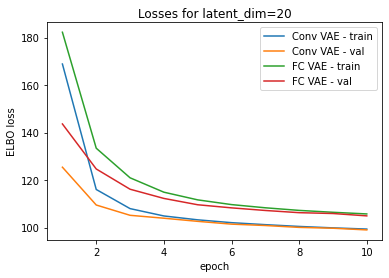

In [ ]:
y_ = conv_train_losses_20
y_1 = conv_test_losses_20
y_2 = fc_train_losses_20
y_3 = fc_test_losses_20
x_ = list(range(1, 10+1))
plt.plot(x_, y_, label="Conv VAE - train")
plt.plot(x_, y_1, label="Conv VAE - val")
plt.plot(x_, y_2, label="FC VAE - train")
plt.plot(x_, y_3, label="FC VAE - val")
plt.xlabel("epoch")
plt.ylabel("ELBO loss")
plt.legend()
plt.title("Losses for latent_dim=20")
plt.show()

In [ ]:
!zip -r /content/file1.zip /content/samples_1
!zip -r /content/file2.zip /content/samples_2
!zip -r /content/file3.zip /content/samples_3
!zip -r /content/file4.zip /content/samples_4

updating: content/samples_1/ (stored 0%)
updating: content/samples_1/sample_2.png (deflated 2%)
updating: content/samples_1/sample_5.png (deflated 2%)
updating: content/samples_1/sample_1.png (deflated 1%)
updating: content/samples_1/sample_4.png (deflated 2%)
updating: content/samples_1/sample_10.png (deflated 3%)
updating: content/samples_1/sample_3.png (deflated 2%)
updating: content/samples_1/sample_6.png (deflated 3%)
updating: content/samples_1/sample_7.png (deflated 3%)
updating: content/samples_1/sample_8.png (deflated 3%)
updating: content/samples_1/sample_9.png (deflated 3%)
  adding: content/samples_2/ (stored 0%)
  adding: content/samples_2/sample_2.png (deflated 3%)
  adding: content/samples_2/sample_5.png (deflated 4%)
  adding: content/samples_2/sample_1.png (deflated 2%)
  adding: content/samples_2/sample_4.png (deflated 4%)
  adding: content/samples_2/sample_10.png (deflated 4%)
  adding: content/samples_2/sample_3.png (deflated 3%)
  adding: content/samples_2/sample_6